In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sat Nov 10 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [61]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-61-a857d1235d28>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [79]:
def prepare_dfs(col='lyap'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, 'splits.pickle'))
    df = df.loc[:, (slice(None), [4], slice(None))].unstack().dropna()[col][4]
    df = df.astype(float)
    
    df_yr = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_response.pickle'))
    df_yr.columns = ['label_r']
    df_yd = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_depressed.pickle'))
    df_yd.columns = ['label_d']
    df_y = df_yr.join(df_yd)
    df = df.join(df_y)
    
    extra = pd.DataFrame(index=df.index, columns=EXTRA)
    for name, row in extra.iterrows():
        extra.loc[name, 'age'] = meta_df.loc[int(row.name.split('-')[1]), 'AGE']
        extra.loc[name, 'sex'] = meta_df.loc[int(row.name.split('-')[1]), 'SEX']
        extra.loc[name, 'sc_bef'] = meta_df.loc[int(row.name.split('-')[1]), 'M_1']
        extra.loc[name, 'sc_aft'] = meta_df.loc[int(row.name.split('-')[1]), 'M_4']
    df = df.join(extra)
    
    rows = [row for row in df.index if row[0].startswith('b')]
    df_aft = df.loc[rows, :]
    df_aft.index = df_aft.index.map(lambda t: int(t.split('-')[1]))
    df_aft = df_aft.sort_index()
    
    rows = [row for row in df.index if row[0].startswith('a')]
    df_bef = df.loc[rows, :]
    df_bef.index = df_bef.index.map(lambda t: int(t.split('-')[1]))
    df_bef = df_bef.sort_index()
     
    return df, df_bef, df_aft
df, df_bef, df_aft = prepare_dfs()

In [83]:
print('Men / Women: {} / {}'.format(len(df[df['sex']==0]), len(df[df['sex']==1])))
age_desc = df['age'].describe()
print('Age summary: \n{}'.format(age_desc))
m1_desc = df['sc_bef'].describe()
print('Measurement 1: \n{}'.format(m1_desc))
m2_desc = df['sc_aft'].describe()
print('Measurement 2: \n{}'.format(m2_desc))

Men / Women: 137 / 39
Age summary: 
count    176.000000
mean      47.840909
std       10.017569
min       30.000000
25%       38.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: age, dtype: float64
Measurement 1: 
count    176.000000
mean      27.414773
std        4.699375
min       17.000000
25%       25.000000
50%       26.000000
75%       30.000000
max       41.000000
Name: sc_bef, dtype: float64
Measurement 2: 
count    176.000000
mean      16.755682
std        7.767513
min        1.000000
25%       10.000000
50%       17.000000
75%       22.000000
max       37.000000
Name: sc_aft, dtype: float64


# Before and after comparison plots

<IPython.core.display.Javascript object>


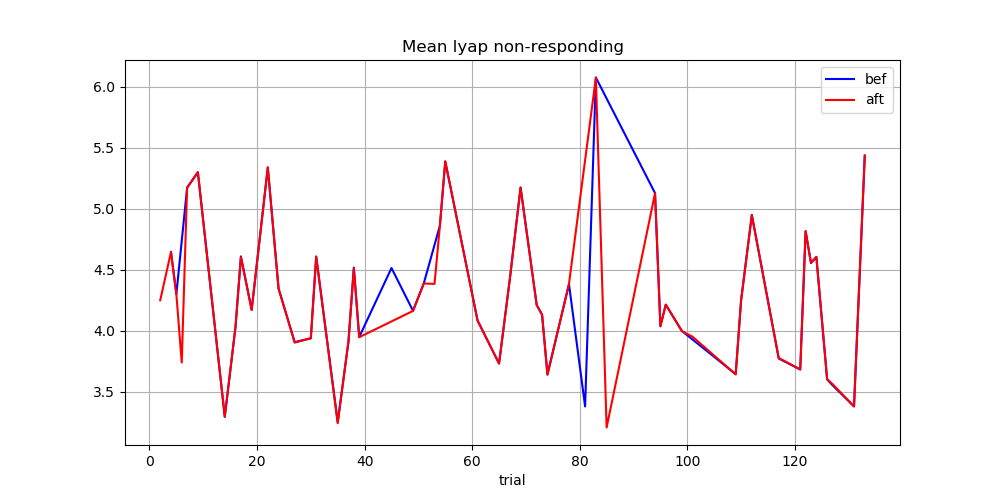

<IPython.core.display.Javascript object>


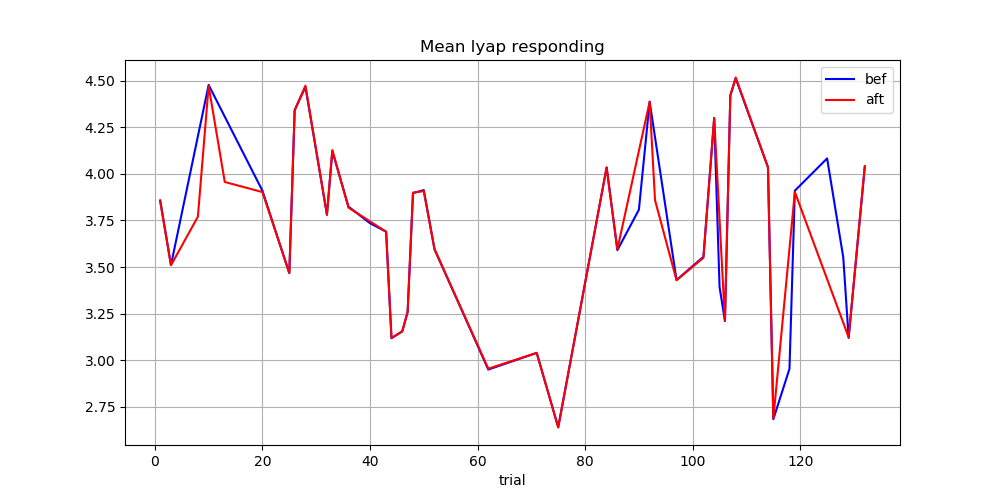

<IPython.core.display.Javascript object>


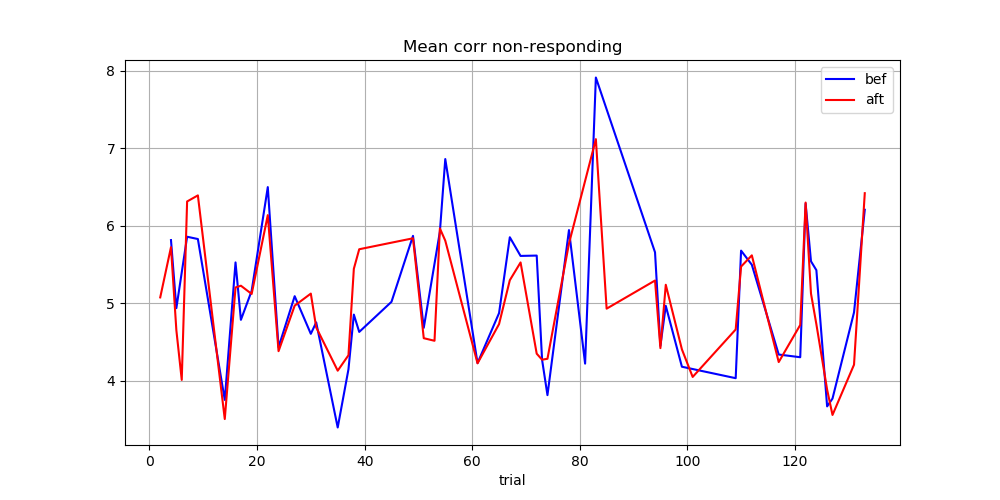

<IPython.core.display.Javascript object>


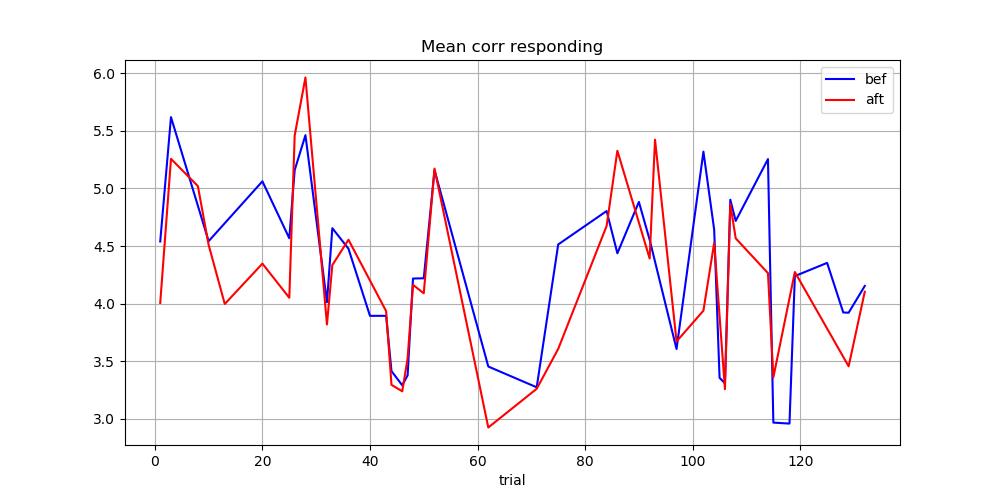

<IPython.core.display.Javascript object>


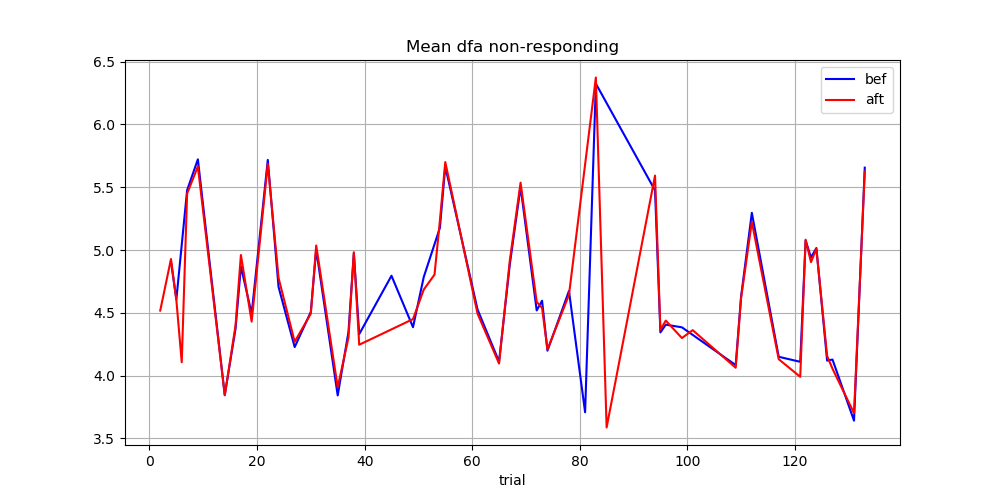

<IPython.core.display.Javascript object>


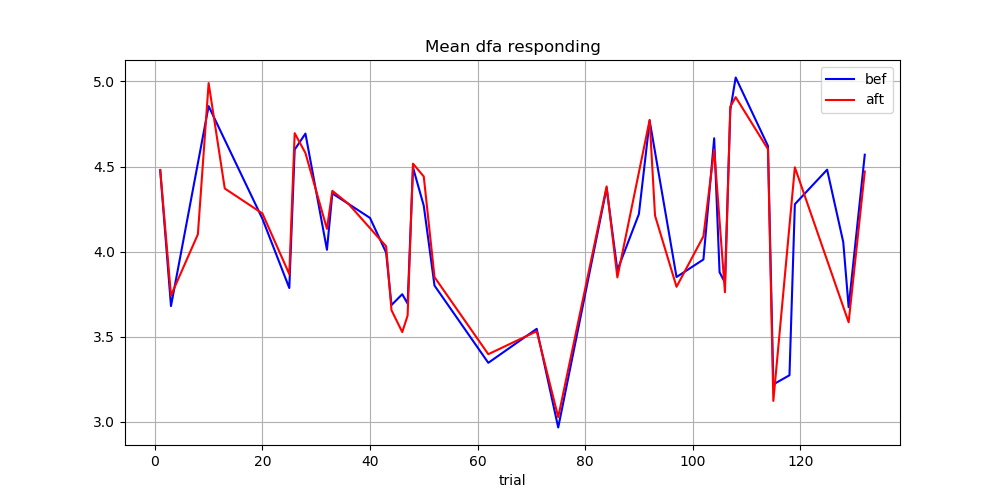

<IPython.core.display.Javascript object>


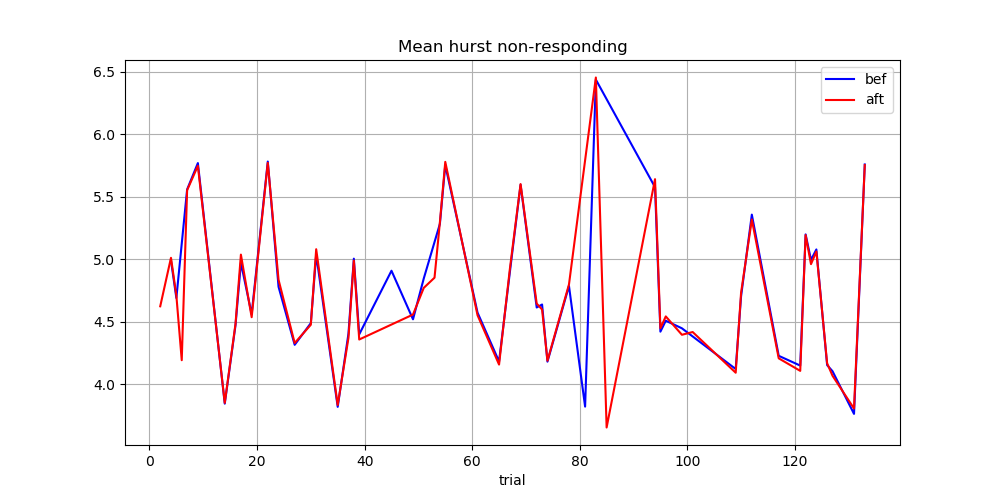

<IPython.core.display.Javascript object>


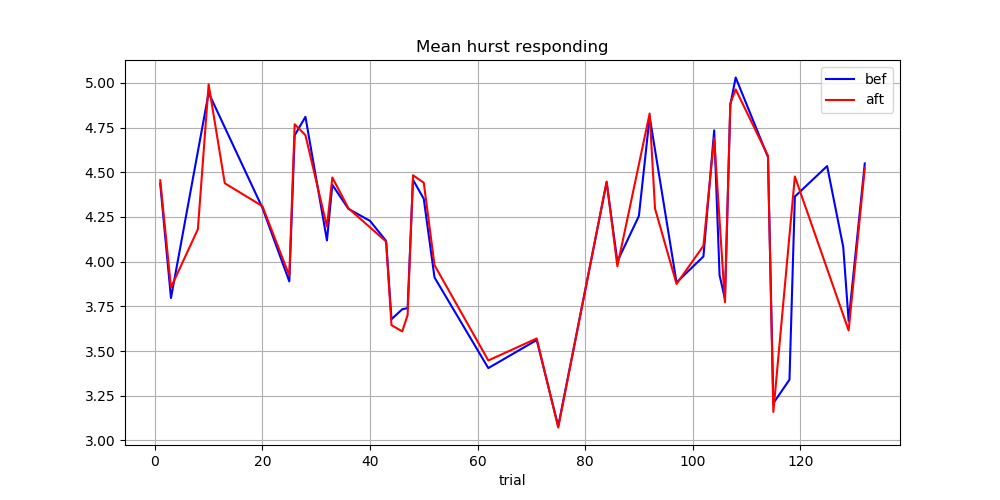

In [100]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='bef')
    ax2 = means_aft.plot(color='red', grid=True, label='aft')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    plot_measure(df_bef, df_aft, col)

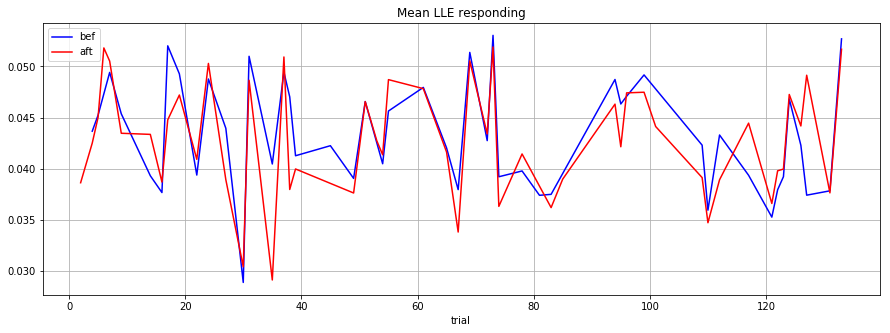

In [202]:
means_bef = df_bef[df_bef['label_r']==0].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==0].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE responding')
plt.show()

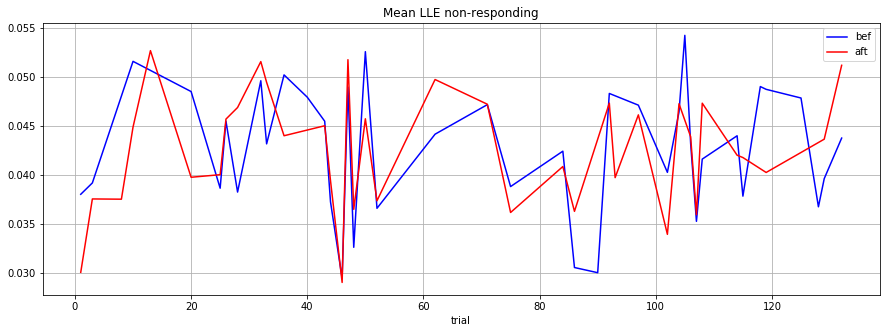

In [203]:
means_bef = df_bef[df_bef['label_r']==1].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==1].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE non-responding')
plt.show()

# Before and after K-S test

In [204]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['label_d']=='L']
    high = df[df['label_d']=='H']
    channel_wise_ks(low, high)
    print()

LYAP
All
Means: 	 0.8432030762784873 	 
Stds: 	 0.043202177978732846 	 !!
C3: 	 0.47106582327896085 	 
C4: 	 0.7238980471658877 	 
Cz: 	 0.2699043637725488 	 
F3: 	 0.06537506455171255 	 !
F4: 	 0.8432030762784878 	 
F7: 	 0.8432030762784873 	 
F8: 	 0.5947978679590012 	 
FP1: 	 0.47106582327896085 	 
FP2: 	 0.9338851942783939 	 
Fz: 	 0.9338851942783939 	 
O1: 	 0.13940285283713824 	 
O2: 	 0.06537506455171255 	 !
P3: 	 0.06537506455171271 	 !
P4: 	 0.19637254341678279 	 
Pz: 	 0.9338851942783942 	 
T3: 	 0.09660834157339039 	 
T4: 	 0.9338851942783939 	 
T5: 	 0.3615587020083678 	 
T6: 	 0.0966083415733906 	 

Non-responding
Means: 	 0.9905859418347901 	 
Stds: 	 0.3396474310092137 	 
C3: 	 0.13980022836749284 	 
C4: 	 0.9848783913874158 	 
Cz: 	 0.5403765897440452 	 
F3: 	 0.4154786567825486 	 
F4: 	 0.7890910097768793 	 
F7: 	 0.8176968538177888 	 
F8: 	 0.5711847535674928 	 
FP1: 	 0.9494954474966849 	 
FP2: 	 0.3556642356008802 	 
Fz: 	 0.6129767887414205 	 
O1: 	 0.3017453390122

P4: 	 0.056943661227086294 	 !
Pz: 	 0.13641023059691487 	 
T3: 	 0.2901617192803718 	 
T4: 	 0.117537336455934 	 
T5: 	 0.117537336455934 	 
T6: 	 0.04026637909353969 	 !!



# PCA

<IPython.core.display.Javascript object>


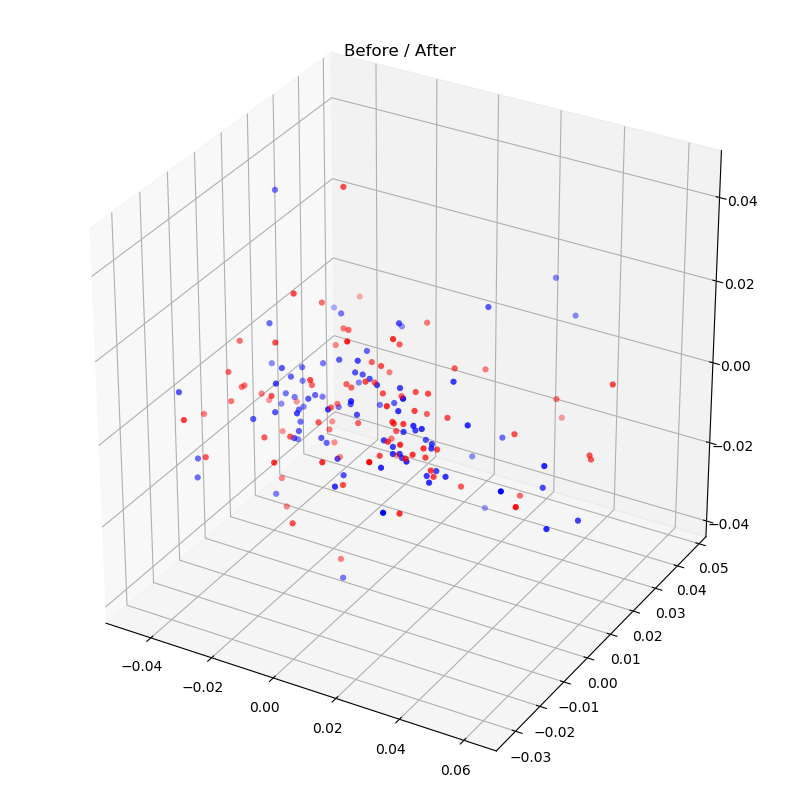

<IPython.core.display.Javascript object>


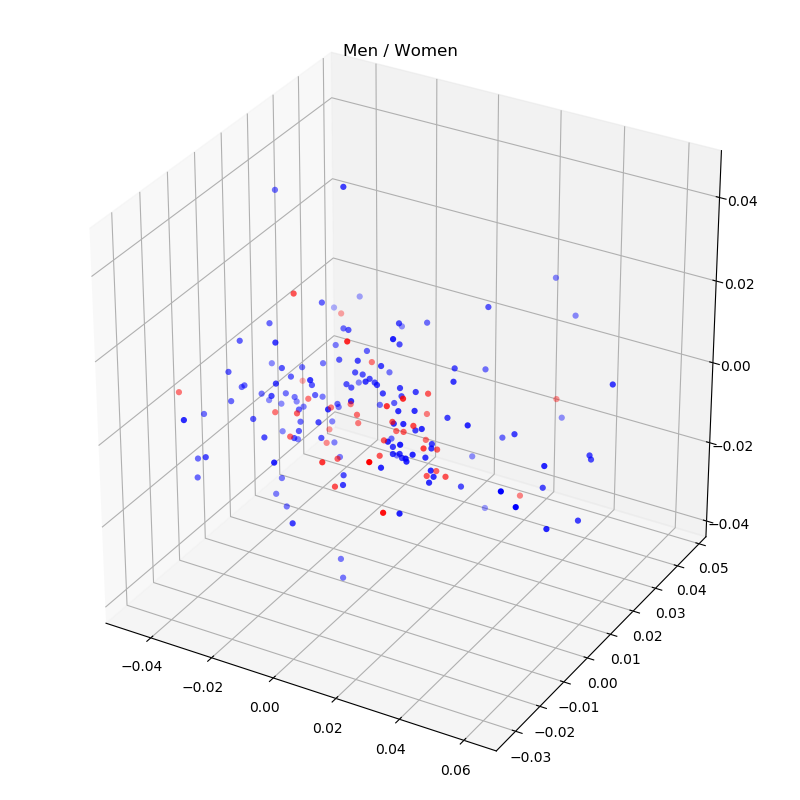

<IPython.core.display.Javascript object>


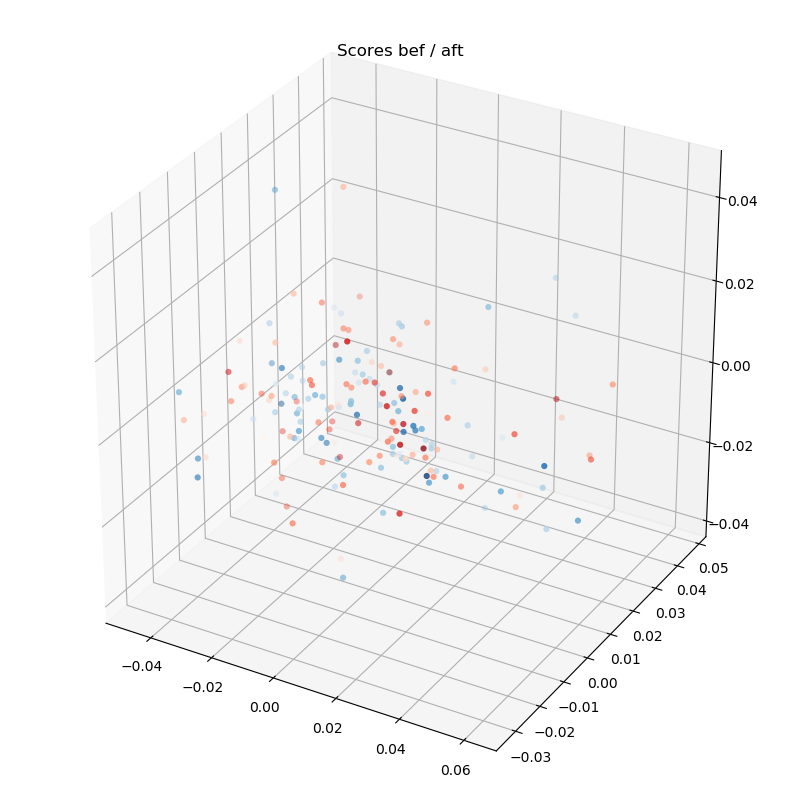

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def plot_pca_2classes(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='')
    plt.title(title)
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

# plot_pca_2classes(df_bef, df_aft, df_bef['age'], df_aft['age'])
plot_pca_2classes(df_bef, df_aft, title="Before / After")
plot_pca_2classes(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
plot_pca_2classes(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")